<a href="https://colab.research.google.com/github/mohadeseh-ghafoori/GOES-Super-Resolution/blob/main/Version_2_of_DL_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Data

In [1]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Dataset with Initial Normalization

In [3]:
# get the directory path
dir_path = "/content/drive/MyDrive/goes"
# get the list of files in the directory
goesfiles = os.listdir(dir_path)
# sort the list by alphabetical order
goesfiles = sorted(goesfiles)
goes=[]
for l in range(len(goesfiles)):
  file_path = os.path.join(dir_path, goesfiles[l])   # get the full path of the file
  data_set = gdal.Open(file_path)  # open the file as a gdal dataset
  band = data_set.GetRasterBand(1)  # get the first band of the dataset
  goes_array = band.ReadAsArray()     # read the band data as a numpy array
  goes_min=np.min(goes_array)
  goes_max=np.max(goes_array)
  array = (goes_array - goes_min)/ ( goes_max - goes_min )
  h,w = array.shape     # get the height and width of the array
  m,n = h//128 , w//128

  for i in range(m+1):
    for j in range(n+1):
      if i!=m and j!=n:
        ar=array[ i*128:(i+1)*128 , j*128 :(j+1)*128 ]
        goes.append(ar)
      if j==n and i!=m:
        ar=array[ i*128:(i+1)*128 , w-128:w ]
        goes.append(ar)
      if i==m and j!=n:
        ar=array[ h-128:h , j*128 :(j+1)*128 ]
        goes.append(ar)
      if i==m and j==n:
        ar=array[ h-128:h , w-128:w ]
        goes.append(ar)

  data_set=None   # set data_set to None to free memory

In [4]:
# get the directory path
dir_path = "/content/drive/MyDrive/viirs"
# get the list of files in the directory
viirsfiles = os.listdir(dir_path)
# sort the list by alphabetical order
viirsfiles = sorted(viirsfiles)
viirs=[]
for k in range(len(viirsfiles)):
  file_path = os.path.join(dir_path, viirsfiles[k])
  data_set = gdal.Open(file_path)
  band = data_set.GetRasterBand(1)
  viirs_array = band.ReadAsArray()
  viirs_max=np.max(viirs_array)
  array= viirs_array / viirs_max
  h,w = array.shape
  m,n = h//128 , w//128

  for i in range(m+1):
    for j in range(n+1):
      if i!=m and j!=n:
        ar=array[ i*128:(i+1)*128 , j*128 :(j+1)*128 ]
        viirs.append(ar)
      if j==n and i!=m:
        ar=array[ i*128:(i+1)*128 , w-128:w ]
        viirs.append(ar)
      if i==m and j!=n:
        ar=array[ h-128:h , j*128 :(j+1)*128 ]
        viirs.append(ar)
      if i==m and j==n:
        ar=array[ h-128:h , w-128:w ]
        viirs.append(ar)

  data_set=None

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from osgeo import gdal
import glob
import os
import numpy as np

goes_arr=np.array(goes)#*255
goes_arr= np.reshape(goes_arr, (-1, 1, 128, 128))
viirs_arr=np.array(viirs)#*255
viirs_arr= np.reshape(viirs_arr, (-1, 1, 128, 128))
input_tensor= torch.tensor(goes_arr)
gt_tensor= torch.tensor(viirs_arr)
dataset = TensorDataset(input_tensor, gt_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

#Dataset with center crop

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from osgeo import gdal
import glob
import os
import numpy as np

#Define the custom dataset class
class MyDataset(Dataset):
  def __init__(self, input_dir, gt_dir, input_transform=None, gt_transform=None):

    #Store the paths to the input images and the ground truth images as attributes
    self.input_paths = glob.glob(os.path.join(input_dir, '*.tiff'))
    self.gt_paths = glob.glob(os.path.join(gt_dir, '*.tif'))


    #Sort the paths to ensure they are aligned
    self.input_paths.sort()
    self.gt_paths.sort()
    #print(self.gt_paths)

    #Store the transform as an attribute
    self.input_transform = input_transform
    self.gt_transform = gt_transform

  def __len__(self):

    #Return the number of samples in the dataset
    return len(self.input_paths)

  def __getitem__(self, idx):

    #Get the paths to the input image and the ground truth image at index idx
    input_path = self.input_paths[idx]
    gt_path = self.gt_paths[idx]

    #Open the geotiff files using GDAL
    input_ds = gdal.Open(input_path)
    gt_ds = gdal.Open(gt_path)

    #access band to access data
    band_input = input_ds.GetRasterBand(1)
    band_gt = gt_ds.GetRasterBand(1)

    #Read the raster data as numpy arrays
    input_array = band_input.ReadAsArray()
    gt_array = band_gt.ReadAsArray()

    #Close the datasets
    input_ds = None
    gt_ds = None

    #Convert the arrays to tensors and add a channel dimension
    input_tensor = torch.unsqueeze(torch.tensor(input_array), 0)
    gt_tensor = torch.unsqueeze(torch.tensor(gt_array), 0)

    input_min = torch.min(input_tensor)
    gt_min = torch.min(gt_tensor)
    input_max = torch.max(input_tensor)
    gt_max = torch.max(gt_tensor)

    #gt_tensor  = (gt_tensor) / (gt_max) * 255

    # input_tensor = ((input_tensor - input_min) / (input_max - input_min)) * 255
    # gt_tensor = (gt_tensor / gt_max) * 255

    #Apply the transform if specified
    if self.input_transform:
      input_tensor = self.input_transform(input_tensor)
    if self.gt_transform:
      gt_tensor = self.gt_transform(gt_tensor)

    input_tensor = ((input_tensor - input_min) / (input_max - input_min)) *255
    gt_tensor  = ((gt_tensor - gt_min) / (gt_max - gt_min)) *255

    #Return a pair of tensors
    return (input_tensor, gt_tensor)


#Define some common transformations for your images
goes_transform = transforms.Compose([
transforms.CenterCrop((128, 128)) # Crop a 128*128 pixel region from the center of the images
#transforms.Normalize(mean=1.1079 , std=1.0921)  #output[channel] = (input[channel] - mean[channel]) / std[channel]
])
viirs_transform = transforms.Compose([
transforms.CenterCrop((128, 128)) # Crop a 128*128 pixel region from the center of the images
#transforms.Normalize(mean=5.7855 , std=42.4841)  #output[channel] = (input[channel] - mean[channel]) / std[channel]
])



#Create an instance of your custom dataset class by passing the paths to the input images and the ground truth images
dataset = MyDataset(input_dir='/content/drive/MyDrive/goes', gt_dir='/content/drive/MyDrive/viirs',
                    input_transform=goes_transform, gt_transform=viirs_transform)

#Create a data loader object by passing your dataset instance
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)



#Plot GOES Batch

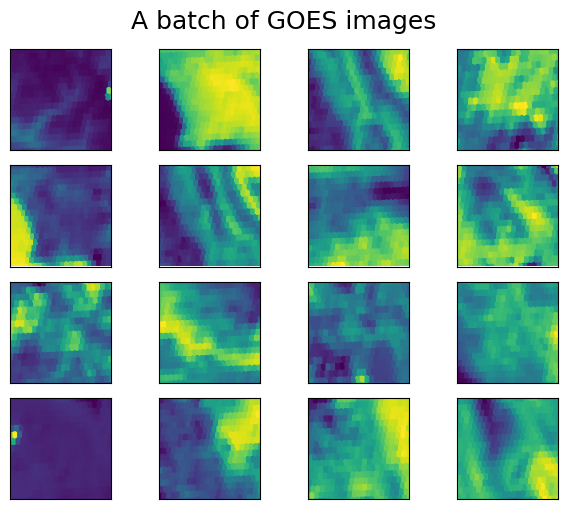

In [6]:
# Import matplotlib.pyplot module
import matplotlib.pyplot as plt
import torchvision

#Iterate over batches of data using a for loop
for l, (goes_batch, viirs_batch) in enumerate(dataloader):
  #print(goes_batch.shape)
  if l==0:
    # Create a figure and a grid of subplots
    fig, ax = plt.subplots(nrows=4, ncols=4)
    # Loop over the subplots and the batch
    for i in range(4):
      for j in range(4):
        # Get the index of the image in the batch
        k = i * 4 + j
        # Get the image from the batch
        img = goes_batch[k,:,:,:]
        npimgs = img.numpy()
        # Display the image on the subplot
        ax[i][j].imshow(np.transpose(npimgs, (1, 2, 0)))
        # Remove the axes ticks
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

        # Adjust the spacing between subplots
        plt.tight_layout()

    plt.suptitle("A batch of GOES images", fontsize=18, y=1.05)
    # Show the plot
    plt.show()
    break





#Plot VIIRS Batch

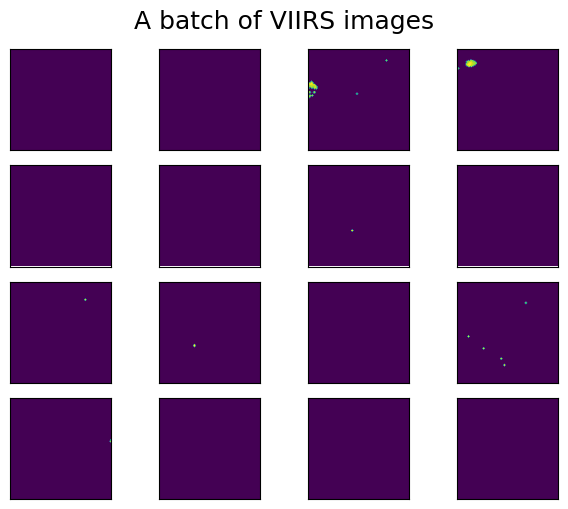

In [26]:
# # Import matplotlib.pyplot module
import matplotlib.pyplot as plt
import torchvision

for l, (goes_batch, viirs_batch) in enumerate(dataloader):
  #print(goes_batch.shape)
  if l==0:
    # Create a figure and a grid of subplots
    fig, ax = plt.subplots(nrows=4, ncols=4)
    # Loop over the subplots and the batch
    for i in range(4):
      for j in range(4):
        # Get the index of the image in the batch
        k = i * 4 + j
        # Get the image from the batch
        img = viirs_batch[k,:,:,:]
        npimgs = img.numpy()
        # Display the image on the subplot
        ax[i][j].imshow(np.transpose(npimgs, (1, 2, 0)))
        # Remove the axes ticks
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

        # Adjust the spacing between subplots
        plt.tight_layout()
    plt.suptitle("A batch of VIIRS images", fontsize=18, y=1.05)
    # Show the plot
    plt.show()
    break

#Model Setup


In [ ]:
import torch
import torch.nn as nn

In [ ]:
class AutoencoderNet(nn.Module):
    def __init__(self):
        super().__init__()
        #Encoder
        self.relu = nn.ReLU()  # define the activation function
        #self.sigmoid = nn.Sigmoid()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=None, padding=0)
        #Decoder
        # Transpose convolutional layers + Convolutional layers
        self.convtranspose1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, padding_mode='zeros',output_padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.convtranspose2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, padding_mode='zeros',output_padding=1)
        self.conv8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv9 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv10 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, padding_mode='zeros')

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.relu(x)
        # Decoder
        x = self.convtranspose1(x)
        x= self.conv6(x)
        x = self.relu(x)
        x= self.conv7(x)
        x = self.relu(x)
        x = self.convtranspose2(x)
        x= self.conv8(x)
        x = self.relu(x)
        x= self.conv9(x)
        x = self.relu(x)
        x= self.conv10(x)
        x = self.relu(x)  #maybe you will need to modify this layer for classification
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=AutoencoderNet().to(device)
# Hyper parameters
num_epochs = 30  #not the problem
batch_size = 16  #not the problem
learning_rate = 0.00001  #not the problem
eps=1e-6
weight_dcy=0.1

#Global Root Mean Square Error (GRMSE)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_dcy)

n_total_steps = len(dataloader)   # get the total number of batches in the data loader
loss_list = [] # create a list to store the losses
for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)  # move the images to the device (cpu or gpu)
        labels = labels.to(device)  # move the labels to the device (cpu or gpu)

        # Forward pass
        outputs = model(images)
        criterion = nn.MSELoss(reduction='mean')
        #criterion = nn.L1Loss(reduction='mean')
        loss = torch.sqrt(criterion(outputs, labels)+ eps) # calculate the root mean squared error between the outputs and the labels
                                                            # adding a small epsilon to avoid zero division
        #loss = criterion(outputs, labels)+ eps
        #loss=torch.sqrt(torch.mean((labels - outputs) ** 2))
        #print(loss)
        # Backward and optimize
        loss.backward()    # compute the gradients of the loss with respect to the model parameters
        optimizer.step()   # update the model parameters using the optimizer
        optimizer.zero_grad() # reset the gradients to zero

        running_loss += loss.item()

    loss_list.append(running_loss / n_total_steps)

    #print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.5f}')

print('Finished Training')
#plot the loss function
plt.plot(loss_list) # plot the list of losses
plt.xlabel('Epoch') # add x-axis label
plt.ylabel('Loss') # add y-axis label
plt.title('Global Root Mean Square Error Loss Function') # add title
plt.show() # show the plot
#PATH = '/content/drive/MyDrive'
#torch.save(model.state_dict(), PATH)

#Global Plus Local RMSE (GLRMSE)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_dcy)

n_total_steps = len(dataloader)   # get the total number of batches in the data loader
loss_list = [] # create a list to store the losses
Wg=9  #a weight factor for Global RMSE
Wl=1  #a weight factor for Local RMSE
for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)  # move the images to the device (cpu or gpu)
        labels = labels.to(device)  # move the labels to the device (cpu or gpu)

        mask = torch.where(labels > 0, 1 , 0)
        # Forward pass
        outputs = model(images)
        numerator = torch.sum(mask * ((labels - outputs)**2))
        denominator = torch.sum(mask)

        #check if the denominator is not zero to avoid division by zero error
        if denominator!=0:
          Local_loss = torch.sqrt(numerator/denominator)
        else:
           Local_loss=0

        #why torch.mean(torch.sqrt(numerator/denominator))
        criterion = nn.MSELoss(reduction='mean')
        Global_loss = torch.sqrt(criterion(outputs, labels) + eps) # calculate the root mean squared error between the outputs and the labels
                                                            # adding a small epsilon to avoid zero division

        #calculate the total loss by adding the weighted Global RMSE and Local RMSE
        loss = Wg*Global_loss + Wl*Local_loss

        #print(loss)
        # Backward and optimize
        loss.backward()    # compute the gradients of the loss with respect to the model parameters
        optimizer.step()   # update the model parameters using the optimizer
        optimizer.zero_grad() # reset the gradients to zero

        running_loss += loss.item()

    loss_list.append(running_loss / n_total_steps)

    #print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Finished Training')
#plot the loss function
plt.plot(loss_list) # plot the list of losses
plt.xlabel('Epoch') # add x-axis label
plt.ylabel('Loss') # add y-axis label
plt.title('Global Plus Local RMSE Loss Function') # add title
plt.show() # show the plot
#PATH = '/content/drive/MyDrive'
#torch.save(model.state_dict(), PATH)

#Jaccard Loss (JL)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class AutoencoderNet(nn.Module):
    def __init__(self):
        super().__init__()
        #Encoder
        self.relu = nn.ReLU()  # define the activation function
        self.sigmoid = nn.Sigmoid()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=None, padding=0)
        #Decoder
        # Transpose convolutional layers + Convolutional layers
        self.convtranspose1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, padding_mode='zeros',output_padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.convtranspose2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, padding_mode='zeros',output_padding=1)
        self.conv8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv9 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv10 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, padding_mode='zeros')

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.relu(x)
        # Decoder
        x = self.convtranspose1(x)
        x= self.conv6(x)
        x = self.relu(x)
        x= self.conv7(x)
        x = self.relu(x)
        x = self.convtranspose2(x)
        x= self.conv8(x)
        x = self.relu(x)
        x= self.conv9(x)
        x = self.relu(x)
        x= self.conv10(x)
        x = self.sigmoid(x)  #maybe you will need to modify this layer for classification
        return x

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_dcy)

n_total_steps = len(dataloader)   # get the total number of batches in the data loader
loss_list = [] # create a list to store the losses
smooth=1e-6
for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)  # move the images to the device (cpu or gpu)
        labels = labels.to(device)  # move the labels to the device (cpu or gpu)

        labels[labels>0] = 1
        # Forward pass
        outputs = model(images)
        #flatten label and prediction tensors
        labels = labels.view(-1)
        outputs = outputs.view(-1)
        sum_labels = torch.sum(labels)
        sum_outputs = torch.sum(outputs)
        prod = outputs * labels
        sum_prod = torch.sum(prod)
        #loss = -torch.mean(( sum_prod ) / ( sum_labels + sum_outputs - sum_prod ))
        loss = -(( sum_prod ) / ( sum_labels + sum_outputs - sum_prod ))


        #print(loss)
        # Backward and optimize
        loss.backward()    # compute the gradients of the loss with respect to the model parameters
        optimizer.step()   # update the model parameters using the optimizer
        optimizer.zero_grad() # reset the gradients to zero

        running_loss += loss.item()

    loss_list.append(running_loss / n_total_steps)

    #print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.6f}')

print('Finished Training')
#plot the loss function
plt.plot(loss_list) # plot the list of losses
plt.xlabel('Epoch') # add x-axis label
plt.ylabel('Loss') # add y-axis label
plt.title('Loss Function') # add title
plt.show() # show the plot
#PATH = '/content/drive/MyDrive'
#torch.save(model.state_dict(), PATH)

#RMSE Plus Jaccard Loss Using Two-Branch Architectur

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class AutoencoderNet(nn.Module):
    def __init__(self):
        super().__init__()
        #Encoder
        self.relu = nn.ReLU()  # define the activation function
        self.sigmoid = nn.Sigmoid()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.pool = nn.MaxPool2d(kernel_size=2, stride=None, padding=0)
        #Decoder
        # Transpose convolutional layers + Convolutional layers
        self.convtranspose1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, padding_mode='zeros',output_padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.convtranspose2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, padding_mode='zeros',output_padding=1)
        self.conv8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv9 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, padding_mode='zeros')
        self.conv10 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, padding_mode='zeros')

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.relu(x)
        # Decoder
        x = self.convtranspose1(x)
        x = self.conv6(x)
        x = self.relu(x)
        x= self.conv7(x)
        x = self.relu(x)
        x = self.convtranspose2(x)
        x = self.conv8(x)
        x = self.relu(x)
        x = self.conv9(x)
        x = self.relu(x)
        x = self.conv10(x)
        x_seg = self.sigmoid(x)
        x_rad = self.relu(x)
        return x_rad,x_seg

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=AutoencoderNet().to(device)
# Hyper parameters
num_epochs = 50  #not the problem
batch_size = 16  #not the problem
learning_rate = 0.0001  #not the problem
eps=1e-6
weight_dcy=0.1

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_dcy)

n_total_steps = len(dataloader)   # get the total number of batches in the data loader
loss_list = [] # create a list to store the losses
smooth=1e-6
Wr = 3
Wj = 1

for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)  # move the images to the device (cpu or gpu)
        labels = labels.to(device)  # move the labels to the device (cpu or gpu)

        labels_seg[labels>0] = 1
        # Forward pass
        outputs_rad, outputs_seg = model(images)
        #flatten label and prediction tensors
        labels_seg = labels_seg.view(-1)
        outputs_seg = outputs_seg.view(-1)
        sum_labels = torch.sum(labels_seg)
        sum_outputs = torch.sum(outputs_seg)
        prod = outputs_seg * labels_seg
        sum_prod = torch.sum(prod)
        #loss = -torch.mean(( sum_prod ) / ( sum_labels + sum_outputs - sum_prod ))
        Jaccard_loss = -(( sum_prod ) / ( sum_labels + sum_outputs - sum_prod ))
        #GRMSE
        criterion = nn.MSELoss(reduction='mean')
        GlobalRMSE_loss = torch.sqrt(criterion(outputs_rad, labels)+ eps)
        loss = (Wr * GlobalRMSE_loss) + (Wj * Jaccard_loss)


        #print(loss)
        # Backward and optimize
        loss.backward()    # compute the gradients of the loss with respect to the model parameters
        optimizer.step()   # update the model parameters using the optimizer
        optimizer.zero_grad() # reset the gradients to zero

        running_loss += loss.item()

    loss_list.append(running_loss / n_total_steps)

    #print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.6f}')

print('Finished Training')
#plot the loss function
plt.plot(loss_list) # plot the list of losses
plt.xlabel('Epoch') # add x-axis label
plt.ylabel('Loss') # add y-axis label
plt.title('Loss Function') # add title
plt.show() # show the plot
#PATH = '/content/drive/MyDrive'
#torch.save(model.state_dict(), PATH)

#test

In [ ]:
import torch
import torch.nn as nn

In [ ]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    # Define the convolutional layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    #self.pool = nn.MaxPool2d(kernel_size=2, padding=0)
    # Define the activation function
    self.relu = nn.ReLU()
    #self.sigmoid = nn.Sigmoid()
    # Define the transpose convolutional layers
    self.convtranspose1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.convtranspose2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.convtranspose3 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    # Apply the convolutional layers and the activation function
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    #x = self.pool(x)
    x = self.conv3(x)
    x = self.relu(x)
    #x = self.pool(x)
    # Apply the transpose convolutional layers and the activation function
    x = self.convtranspose1(x)
    x = self.relu(x)
    x = self.convtranspose2(x)
    x = self.relu(x)
    x = self.convtranspose3(x)
    #x_seg = self.sigmoid(x)
    x_rad = self.relu(x)
    return x_rad

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=SimpleCNN().to(device)
# Hyper parameters
num_epochs = 30  #not the problem
batch_size = 16  #not the problem
learning_rate = 1e-5  #not the problem
eps=1e-6
weight_dcy=0.1

Finished Training


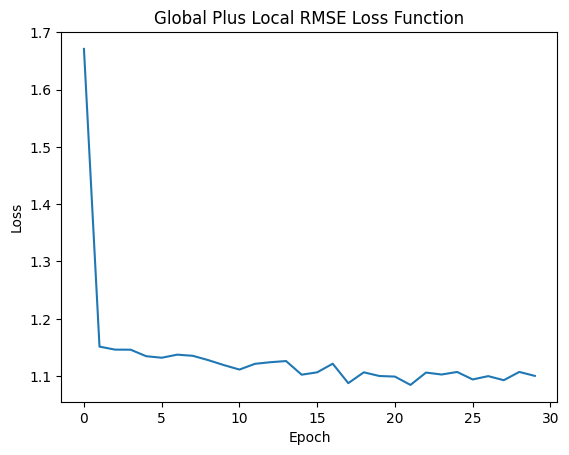

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_dcy)

n_total_steps = len(dataloader)   # get the total number of batches in the data loader
loss_list = [] # create a list to store the losses
Wg=9  #a weight factor for Global RMSE
Wl=1  #a weight factor for Local RMSE
for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)  # move the images to the device (cpu or gpu)
        labels = labels.to(device)  # move the labels to the device (cpu or gpu)

        mask = torch.where(labels > 0, 1 , 0)
        # Forward pass
        outputs = model(images)
        numerator = torch.sum(mask * ((labels - outputs)**2))
        denominator = torch.sum(mask)

        #check if the denominator is not zero to avoid division by zero error
        if denominator!=0:
          Local_loss = torch.sqrt(numerator/denominator)
        else:
           Local_loss=0

        #why torch.mean(torch.sqrt(numerator/denominator))
        criterion = nn.MSELoss(reduction='mean')
        Global_loss = torch.sqrt(criterion(outputs, labels) + eps) # calculate the root mean squared error between the outputs and the labels
                                                            # adding a small epsilon to avoid zero division

        #calculate the total loss by adding the weighted Global RMSE and Local RMSE
        loss = Wg*Global_loss + Wl*Local_loss

        #print(loss)
        # Backward and optimize
        loss.backward()    # compute the gradients of the loss with respect to the model parameters
        optimizer.step()   # update the model parameters using the optimizer
        optimizer.zero_grad() # reset the gradients to zero

        running_loss += loss.item()

    loss_list.append(running_loss / n_total_steps)

    #print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Finished Training')
#plot the loss function
plt.plot(loss_list) # plot the list of losses
plt.xlabel('Epoch') # add x-axis label
plt.ylabel('Loss') # add y-axis label
plt.title('Global Plus Local RMSE Loss Function') # add title
plt.show() # show the plot

In [ ]:
PATH = './model_weights.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
# get the VIIRS path
viirs_path = "/content/drive/MyDrive/viirs/viirs_event0_group10.tif"
viirs=[]
viirs_data_set = gdal.Open(viirs_path)
#access band to access data
viirs_band = viirs_data_set.GetRasterBand(1)
viirs_array = viirs_band.ReadAsArray()
viirs_max=np.max(viirs_array)
array= viirs_array / viirs_max
h,w = array.shape
m,n = h//128 , w//128

for i in range(m+1):
  for j in range(n+1):
    if i!=m and j!=n:
      ar=array[ i*128:(i+1)*128 , j*128 :(j+1)*128 ]
      viirs.append(ar)
    if j==n and i!=m:
      ar=array[ i*128:(i+1)*128 , w-128:w ]
      viirs.append(ar)
    if i==m and j!=n:
      ar=array[ h-128:h , j*128 :(j+1)*128 ]
      viirs.append(ar)
    if i==m and j==n:
      ar=array[ h-128:h , w-128:w ]
      viirs.append(ar)

data_set=None

In [ ]:
# get the GOES path
goes_path = "/content/drive/MyDrive/goes/goes_event0_group10.tiff"
goes_data_set = gdal.Open(goes_path)  # open the file as a gdal dataset
goes_band = goes_data_set.GetRasterBand(1)
goes_array = goes_band.ReadAsArray()     # read the band data as a numpy array
goes_min=np.min(goes_array)
goes_max=np.max(goes_array)
array = (goes_array - goes_min)/ ( goes_max - goes_min )
goes=[]
h,w = array.shape     # get the height and width of the array
m,n = h//128 , w//128
for i in range(m+1):
  for j in range(n+1):
    if i!=m and j!=n:
      ar=array[ i*128:(i+1)*128 , j*128 :(j+1)*128 ]
      goes.append(ar)
    if j==n and i!=m:
      ar=array[ i*128:(i+1)*128 , w-128:w ]
      goes.append(ar)
    if i==m and j!=n:
      ar=array[ h-128:h , j*128 :(j+1)*128 ]
      goes.append(ar)
    if i==m and j==n:
      ar=array[ h-128:h , w-128:w ]
      goes.append(ar)

data_set=None   # set data_set to None to free memory

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from osgeo import gdal
import glob
import os
import numpy as np

goes_arr=np.array(goes)
goes_arr= np.reshape(goes_arr, (-1, 1, 128, 128))
viirs_arr=np.array(viirs)
viirs_arr= np.reshape(viirs_arr, (-1, 1, 128, 128))
input_tensor_test= torch.tensor(goes_arr)
gt_tensor_test= torch.tensor(viirs_arr)
testset = TensorDataset(input_tensor_test, gt_tensor_test)
testloader = DataLoader(testset, batch_size=16, shuffle=False)

In [ ]:
# create a new instance of the model
model = SimpleCNN()
# load the model state dictionary
model.load_state_dict(torch.load(PATH))
# set the model to evaluation mode
model.eval()

with torch.no_grad():
  outputs=model(input_tensor_test)

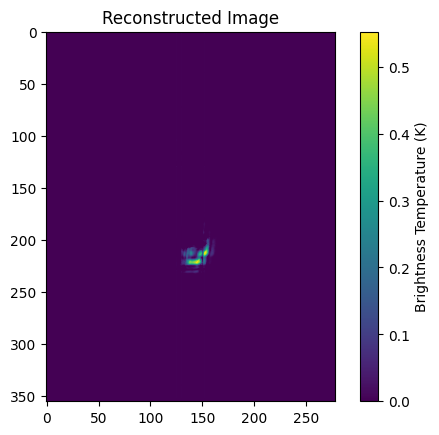

In [ ]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

# Assuming 'goes' is the list of windows
window_size = 128
m, n = h // window_size, w // window_size

# Initialize the empty array for the reconstructed image
network_reconstructed_image = np.zeros((h, w), dtype=np.float32)

# Counter for iterating over the 'goes' list
k = 0

for i in range(m + 1):
  for j in range(n + 1):
    # Extract the window from the 'goes' list
    window = outputs[k]
    k += 1
    if i!=m and j!=n:
      network_reconstructed_image[ i*128:(i+1)*128 , j*128 :(j+1)*128 ]= window
    if j==n and i!=m:
      network_reconstructed_image[ i*128:(i+1)*128 , w-128:w ]= window
    if i==m and j!=n:
      network_reconstructed_image[ h-128:h , j*128 :(j+1)*128 ]= window
    if i==m and j==n:
      network_reconstructed_image[ h-128:h , w-128:w ]= window




# Rescale the values to the original range (assuming the data was normalized)
#reconstructed_image = reconstructed_image * (array_max - array_min) + array_min

# Display the reconstructed image
plt.imshow(network_reconstructed_image)#, cmap='gray')
plt.title('Reconstructed Image')
plt.colorbar(label="Brightness Temperature (K)")
plt.show()



#Evaluation

In [ ]:
import numpy as np
import torch
from skimage import filters
import matplotlib.pyplot as plt
from skimage import io, color

# Assuming 'outputs' is a PyTorch tensor, convert it to a NumPy array
# image = outputs.numpy()
image = network_reconstructed_image

# Ensure the image is 2D (grayscale)
if len(image.shape) == 3:
    image = color.rgb2gray(image)

# Apply Otsu's thresholding
threshold_value = filters.threshold_otsu(image)
thr_image = np.copy(image)

# Apply thresholding efficiently using NumPy
thr_image[thr_image < threshold_value] = 0

# Convert binary image to PyTorch tensor
#thr_image_tensor = torch.tensor(thr_image, dtype=torch.float32)

# Display the original and thresholded images
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image)#, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(thr_image)#, cmap='gray')
plt.title('Thresholded Image')

plt.show()


In [ ]:
def Eval_iou(y_true=None, y_pred=None):
  y_true[y_true>0] = 1
  y_pred[y_pred>0] = 1
  #flatten label and prediction tensors
  y_true = y_true.flatten()
  y_pred = y_pred.flatten()
  sum_labels = np.sum(y_true)
  sum_outputs = np.sum(y_pred)
  prod = y_pred * y_true
  sum_prod = np.sum(prod)
  iou = ( sum_prod ) / ( sum_labels + sum_outputs - sum_prod )
  return iou


In [ ]:
Eval_iou(y_true=gt_reconstructed_image, y_pred=thr_image)

In [ ]:
def Eval_ipsnr(y_true=None, y_pred=None):
  maxval = np.max(y_true)
  intersect = y_true * y_pred
  mask = torch.where(intersect > 0, 1 , 0)
  numerator = np.sum(mask * ((y_true - y_pred)**2))
  denominator = np.sum(mask)
  IRMSE = np.sqrt(numerator / denominator)
  ipsnr = np.log10(maxval / IRMSE)
  return ipsnr

In [ ]:
Eval_ipsnr(y_true=gt_reconstructed_image, y_pred=thr_image)